In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.api as sm
import pyodbc
import urllib
import joblib
import json
from sqlalchemy import create_engine 
from datetime import datetime, date
import sys
pd.set_option('display.max_columns', None)

### Load the IBV Score Results from the SQL query; 
#### Each row is an application with the input data to the model

In [2]:
server = '192.168.1.15'
username = 'Junchen'
password = '9DFXjhhlR3k5'
database = 'LF_LMSMaster'

params = urllib.parse.quote_plus(
    "DRIVER={ODBC Driver 18 for SQL Server};"
    f"SERVER={server},1433;DATABASE={database};UID={username};PWD={password};"
    "Encrypt=yes;TrustServerCertificate=yes;"
)
engine = create_engine(f"mssql+pyodbc:///?odbc_connect={params}")

cnxn = engine.connect()

query1 = f""" 
select * from 
(select B.*, row_number() over (partition by B.ApplicationID, B.PortfolioID order by CreateTime desc) as RN
from [LF_LMSMaster].[dbo].[ScoringPythonResult] B
join LF_LMSMaster..Application A on A.Application_ID = B.ApplicationID and A.PortFolioID = B.PortFolioID
left join LF_LMSMaster..Loans L on A.Application_ID = L.ApplicationID and A.PortFolioID = L.PortFolioID
where iLabel = 'IBVBand'  and L.LoanStatus not in ('V','W','G','K') -- and ModelID = 2
-- and A.ApplicationSteps not like '%R%' and A.ApplicationSteps not like '%O%'
) A where A.RN = 1
"""

df = pd.read_sql(query1, cnxn)

### Load the python string to a json dictionary and save it locally

In [3]:
for i,j in zip(df.ApplicationID.values, df.Svector.values):
    try:
        with open('retroData/IBV_'+str(i)+'.json', 'w') as f:
            json.dump( json.loads(j), f, indent=4, separators=(',', ':'))
    except:
        print(i)

In [4]:
# last processed ApplicationID.
i

126164

In [5]:
# json.loads(j)
len(df)

9655

### Review the data quality: $Tasty$

In [6]:
with open('/Users/starsrain/2025_concord/loonie_rebuild_2025/retroData/IBV_79.json', 'r') as f:
    x  = f.read()
x[:200]

'{\n    "Model1Score":"0",\n    "NDBand":"0",\n    "Sys_reqAmt":"500.0000",\n    "Sys_Time":"4/26/2023 12:11:55 PM",\n    "Sys_payfreq":"B",\n    "CreditBook":{\n        "accountnumber":65,\n        "search_qu'

### Load historical transactions field inside the JSON file

In [7]:
# Check some of the transactions
k = json.loads(x)
k = pd.read_json(json.dumps(k['Historical_Transactions']))
k.head(3)

/var/folders/b7/d1qg7gm9009f_cps7l193hch0000gn/T/ipykernel_74994/317363692.py:3: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  k = pd.read_json(json.dumps(k['Historical_Transactions']))


,name,transaction_id,account_id,category,category_id,transaction_type,payment_channel,TransactionCode,PaymentMeta,amount,iso_currency_code,unofficial_currency_code,CurrencyCode,date,authorized_date,location,pending,pending_transaction_id,account_owner
0,HAYMAN J _V,jJxnpwX83YUKJeVvwzxVsX4x58AMenHvpJAjP,d0vmanxBLQC9E6y4kwvyiEnkd7Y7PDToevVkn,"[Transfer, Third Party, PayPal]",21010004,2,3,0,NaN,-57.17,CAD,,CAD,2023-04-24,NaN,NaN,False,,
1,NSF RETURN FEE,r9Ddp3P6rqizLj3159X3iPYN1DrE6AFrQzYwx,d0vmanxBLQC9E6y4kwvyiEnkd7Y7PDToevVkn,"[Bank Fees, Insufficient Funds]",10007000,2,3,0,NaN,48.00,CAD,,CAD,2023-04-24,NaN,NaN,False,,
2,7-Eleven,m5Z7pDwPk6tZ5KkbLzmkSq45Xa3roPf8pLRvg,d0vmanxBLQC9E6y4kwvyiEnkd7Y7PDToevVkn,"[Shops, Convenience Stores]",19015000,1,2,0,NaN,13.32,CAD,,CAD,2023-04-21,NaN,NaN,False,,


In [ ]:
loan_mask = k['category'].astype('string').str.contains('Loans', case=False, na=False)
k_filtered = k.loc[loan_mask]
k_filtered.head(10)

,name,transaction_id,account_id,category,category_id,transaction_type,payment_channel,TransactionCode,PaymentMeta,amount,iso_currency_code,unofficial_currency_code,CurrencyCode,date,authorized_date,location,pending,pending_transaction_id,account_owner
24,SPEEDY SK MSP,vdBDpAyRgKHZqxoe37YoSbkpdYRAjyfpaAX0d,d0vmanxBLQC9E6y4kwvyiEnkd7Y7PDToevVkn,"[Service, Financial, Loans and Mortgages]",18020004,1,1,0,NaN,493.14,CAD,,CAD,2023-04-21,NaN,NaN,False,,
60,SPEEDY SK MSP,g4r7aZzpPXFa41mKVjYmSzoBxQ3w8Nt60yB6j,d0vmanxBLQC9E6y4kwvyiEnkd7Y7PDToevVkn,"[Service, Financial, Loans and Mortgages]",18020004,1,1,0,NaN,608.40,CAD,,CAD,2023-04-06,NaN,NaN,False,,
136,SPEEDY SK MSP,VwmD8oO0XJs0wjkEbnmkSALbqQbJrjtjKDbX9,d0vmanxBLQC9E6y4kwvyiEnkd7Y7PDToevVkn,"[Service, Financial, Loans and Mortgages]",18020004,1,1,0,NaN,585.00,CAD,,CAD,2023-03-24,NaN,NaN,False,,
162,STRATUS FINANCE MSP,OgrAX8QbyvH1D3gYVMjguZrwoBwJ8gUg910gd,d0vmanxBLQC9E6y4kwvyiEnkd7Y7PDToevVkn,"[Service, Financial, Loans and Mortgages]",18020004,1,3,0,NaN,-500.00,CAD,,CAD,2023-03-17,NaN,NaN,False,,
223,SPEEDY SK MSP,pg67pqDPx1HKwv8Z9q08s7gRNjRBkJs4mr93n,d0vmanxBLQC9E6y4kwvyiEnkd7Y7PDToevVkn,"[Service, Financial, Loans and Mortgages]",18020004,1,1,0,NaN,585.00,CAD,,CAD,2023-03-10,NaN,NaN,False,,
268,SPEEDY SK MSP,bAkRMZ94wEf9zd1vqQm1ik46jN6OdqfDOvXqq,d0vmanxBLQC9E6y4kwvyiEnkd7Y7PDToevVkn,"[Service, Financial, Loans and Mortgages]",18020004,1,1,0,NaN,468.00,CAD,,CAD,2023-02-23,NaN,NaN,False,,
281,SPEEDY SK MSP,Z1DmapJ9Xosy1xjEneDjSBrazQaORKfkr7MRq,d0vmanxBLQC9E6y4kwvyiEnkd7Y7PDToevVkn,"[Service, Financial, Loans and Mortgages]",18020004,1,1,0,NaN,468.00,CAD,,CAD,2023-02-10,NaN,NaN,False,,
313,SPEEDY SK MSP,NbjkR8vq3Ata8Bg7oO0gSOzMB8MgRrsL8n1YK,d0vmanxBLQC9E6y4kwvyiEnkd7Y7PDToevVkn,"[Service, Financial, Loans and Mortgages]",18020004,1,1,0,NaN,468.00,CAD,,CAD,2023-01-26,NaN,NaN,False,,


In [ ]:
stop_mask = k['name'].astype('string').str.contains('stop', case=False, na=False)
k_stop_filtered = k.loc[stop_mask]
k_stop_filtered.head(10)

,name,transaction_id,account_id,category,category_id,transaction_type,payment_channel,TransactionCode,PaymentMeta,amount,iso_currency_code,unofficial_currency_code,CurrencyCode,date,authorized_date,location,pending,pending_transaction_id,account_owner


In [ ]:
k.columns, k.dtypes

(Index(['name', 'transaction_id', 'account_id', 'category', 'category_id',
        'transaction_type', 'payment_channel', 'TransactionCode', 'PaymentMeta',
        'amount', 'iso_currency_code', 'unofficial_currency_code',
        'CurrencyCode', 'date', 'authorized_date', 'location', 'pending',
        'pending_transaction_id', 'account_owner'],
       dtype='object'),
 name                                object
 transaction_id                      object
 account_id                          object
 category                            object
 category_id                          int64
 transaction_type                     int64
 payment_channel                      int64
 TransactionCode                      int64
 PaymentMeta                        float64
 amount                             float64
 iso_currency_code                   object
 unofficial_currency_code            object
 CurrencyCode                        object
 date                        datetime64[ns]
 authorized

In [ ]:
k.account_owner.unique()

array([''], dtype=object)

In [ ]:
# Table 1: LF_Plaid_Historical_Transactions
'name': varchar,
'transaction_id': varchar,
'account_id': varchar,
'category': varchar, 
'category_id': int,
'transaction_type': int, 
'payment_channel': int,
'TransactionCode': int, 
'PaymentMeta': float64 with null values,
'amount': float,
'iso_currency_code': varchar, 
'unofficial_currency_code': varchar,
'CurrencyCode': varchar,
'date': date (eg '2023-05-12'), 
'authorized_date': datetime  (eg '2023-05-12T00:00:00'),
'location': varchar,
'pending': boolean value (eg True/False),
'pending_transaction_id':varchar, 
'account_owner': varchar

# Table 2: LF_Plaid_Account    
'Application_ID': int
'PortfolioID': int
'account_id': varchar

In [ ]:
# Table 1: LF_Plaid_Historical_Transactions
'name': varchar,
'transaction_id': varchar,
'account_id': varchar,
'category': varchar, 
'category_id': int,
'transaction_type': int, 
'payment_channel': int,
'TransactionCode': int, 
'PaymentMeta': float64 with null values,
'amount': float,
'iso_currency_code': varchar, 
'unofficial_currency_code': varchar,
'CurrencyCode': varchar,
'date': date (eg '2023-05-12'), 
'authorized_date': datetime  (eg '2023-05-12T00:00:00'),
'location': varchar,
'pending': boolean value (eg True/False),
'pending_transaction_id':varchar, 
'account_owner': varchar  
'Application_ID': int
'PortfolioID': int

### Switch to looking at Historical_Balance instead of Historical_Transactions

In [ ]:
from pandas import json_normalize

k_balance = json.loads(x)
df = json_normalize(
    k_balance, 
    record_path=['Historical_Balance','report','items','accounts','historical_balances'],
    meta=[['Historical_Balance','report','items','accounts','account_id']],
    errors='ignore'
)

ValueError: Mixing dicts with non-Series may lead to ambiguous ordering.

In [ ]:
len(k['Historical_Balance']['report']['items'][0]['accounts'])

KeyError: 'Historical_Balance'

In [ ]:
k['Historical_Balance']['report']['items'][0]['accounts'][0]

{'account_id': 'AZAm773rJPUDYYNnqz7NiJmZj49gwpUwVVZDg',
 'balances': {'available': 0,
  'current': 0,
  'iso_currency_code': 'CAD',
  'limit': None,
  'unofficial_currency_code': None},
 'days_available': 90,
 'historical_balances': [{'current': 0,
   'date': '2023-05-11',
   'iso_currency_code': 'CAD',
   'unofficial_currency_code': None},
  {'current': 0,
   'date': '2023-05-10',
   'iso_currency_code': 'CAD',
   'unofficial_currency_code': None},
  {'current': 46.35,
   'date': '2023-05-09',
   'iso_currency_code': 'CAD',
   'unofficial_currency_code': None},
  {'current': 46.35,
   'date': '2023-05-08',
   'iso_currency_code': 'CAD',
   'unofficial_currency_code': None},
  {'current': 46.35,
   'date': '2023-05-07',
   'iso_currency_code': 'CAD',
   'unofficial_currency_code': None},
  {'current': 46.35,
   'date': '2023-05-06',
   'iso_currency_code': 'CAD',
   'unofficial_currency_code': None},
  {'current': 46.35,
   'date': '2023-05-05',
   'iso_currency_code': 'CAD',
   'unoff

In [ ]:
k['Historical_Balance']['report']['items'][0]['accounts'][1] # The second account is the account for transactions

{'account_id': 'ke8wBBx6NEU8zzLbpvZLiO0Xa3bdwqFb55pYa',
 'balances': {'available': 797.87,
  'current': 797.87,
  'iso_currency_code': 'CAD',
  'limit': None,
  'unofficial_currency_code': None},
 'days_available': 90,
 'historical_balances': [{'current': 787.67,
   'date': '2023-05-11',
   'iso_currency_code': 'CAD',
   'unofficial_currency_code': None},
  {'current': 13.57,
   'date': '2023-05-10',
   'iso_currency_code': 'CAD',
   'unofficial_currency_code': None},
  {'current': 44.13,
   'date': '2023-05-09',
   'iso_currency_code': 'CAD',
   'unofficial_currency_code': None},
  {'current': 48.64,
   'date': '2023-05-08',
   'iso_currency_code': 'CAD',
   'unofficial_currency_code': None},
  {'current': 531.78,
   'date': '2023-05-07',
   'iso_currency_code': 'CAD',
   'unofficial_currency_code': None},
  {'current': 531.78,
   'date': '2023-05-06',
   'iso_currency_code': 'CAD',
   'unofficial_currency_code': None},
  {'current': 531.78,
   'date': '2023-05-05',
   'iso_currency_c

In [ ]:
k['Historical_Balance']['report']['items'][0]['accounts'][2]

{'account_id': 'vedoYYyAPMUqKKvBzgEvf54dVRv0O9upZZY4P',
 'balances': {'available': 0,
  'current': 0,
  'iso_currency_code': 'CAD',
  'limit': None,
  'unofficial_currency_code': None},
 'days_available': 90,
 'historical_balances': [{'current': 0,
   'date': '2023-05-11',
   'iso_currency_code': 'CAD',
   'unofficial_currency_code': None},
  {'current': 0,
   'date': '2023-05-10',
   'iso_currency_code': 'CAD',
   'unofficial_currency_code': None},
  {'current': 0,
   'date': '2023-05-09',
   'iso_currency_code': 'CAD',
   'unofficial_currency_code': None},
  {'current': 0,
   'date': '2023-05-08',
   'iso_currency_code': 'CAD',
   'unofficial_currency_code': None},
  {'current': 0,
   'date': '2023-05-07',
   'iso_currency_code': 'CAD',
   'unofficial_currency_code': None},
  {'current': 0,
   'date': '2023-05-06',
   'iso_currency_code': 'CAD',
   'unofficial_currency_code': None},
  {'current': 0,
   'date': '2023-05-05',
   'iso_currency_code': 'CAD',
   'unofficial_currency_code'

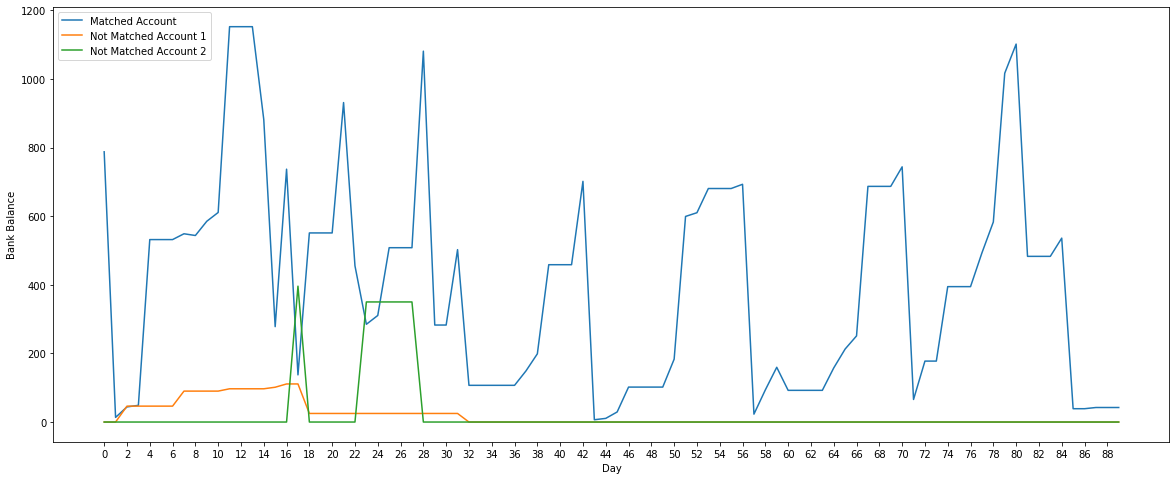

In [ ]:
plt.figure(figsize = (20,8))
pd.read_json(json.dumps(k['Historical_Balance']['report']['items'][0]['accounts'][1]['historical_balances'])
            ).current[::-1].plot(label = 'Matched Account')
pd.read_json(json.dumps(k['Historical_Balance']['report']['items'][0]['accounts'][0]['historical_balances'])
            ).current[::-1].plot(label = 'Not Matched Account 1')
pd.read_json(json.dumps(k['Historical_Balance']['report']['items'][0]['accounts'][2]['historical_balances'])
            ).current[::-1].plot(label = 'Not Matched Account 2')
plt.legend()
plt.xlabel('Day')
plt.xticks(np.arange(0,len(pd.read_json(json.dumps(k['Historical_Balance']['report']['items'][0]['accounts'][1]['historical_balances']))
            ),2))
plt.ylabel('Bank Balance')
plt.show() # This one catches the biweekly payments

In [ ]:
pd.read_json(json.dumps(k['Historical_Balance']['report']['items'][0]['accounts'][1]['historical_balances']))

,current,date,iso_currency_code,unofficial_currency_code
0,787.67,2023-05-11,CAD,NaN
1,13.57,2023-05-10,CAD,NaN
2,44.13,2023-05-09,CAD,NaN
3,48.64,2023-05-08,CAD,NaN
4,531.78,2023-05-07,CAD,NaN
...,...,...,...,...
85,38.84,2023-02-15,CAD,NaN
86,38.84,2023-02-14,CAD,NaN
87,42.35,2023-02-13,CAD,NaN
88,42.35,2023-02-12,CAD,NaN


In [ ]:
import re
a = 'opploans'

re.search(r'loans\b',a)

<re.Match object; span=(3, 8), match='loans'>

In [ ]:
# check after flinks integration
server = '192.168.1.15'
username = 'AWang'
password = '9Kha8H54FyapCq9w'
database = 'LF_LMSMaster'
params = urllib.parse.quote_plus('DRIVER={SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
engine = create_engine('mssql+pyodbc:///?odbc_connect=%s' % params,fast_executemany=True)

cnxn = engine.connect()

query1 = f""" 
select *,
(select Svector  
from [LF_LMSMaster].[dbo].[ScoringPythonResult]  A
where A.ApplicationID=B.ApplicationID and A.PortfolioID = B.PortfolioID for json auto) as Json_Svector
from [LF_LMSMaster].[dbo].[ScoringPythonResult] B
where scoreID = 8709
order by Createtime desc
"""

df = pd.read_sql(query1, cnxn)

In [ ]:
x = json.loads(df.Svector.values[0])
x['Historical_Transactions']

[]

In [ ]:
cnxn.close()

In [ ]:
# data processing tools
import pandas as pd
import numpy as np
from datetime import datetime, date, time
import math
import re
import scipy

# plots 
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

# system functionalities
import warnings
import os
import sys
import logging

# modeling:
import joblib
import statsmodels.api as sm
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, silhouette_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from scipy.cluster.hierarchy import linkage, fcluster
from nltk.corpus import stopwords
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold

# data loading & transmission
import json
import pyodbc
import urllib
from tqdm import tqdm
from sqlalchemy import create_engine, text